# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.185891,True,4.242793
1,0.582213,False,3.464016
2,1.363114,False,3.662493
3,-1.019266,True,3.403171
4,0.681019,True,8.409808
...,...,...,...
995,-0.220522,True,5.022421
996,0.340400,False,1.319468
997,0.898718,True,7.132420
998,1.245058,False,4.040012


<AxesSubplot:xlabel='v0'>

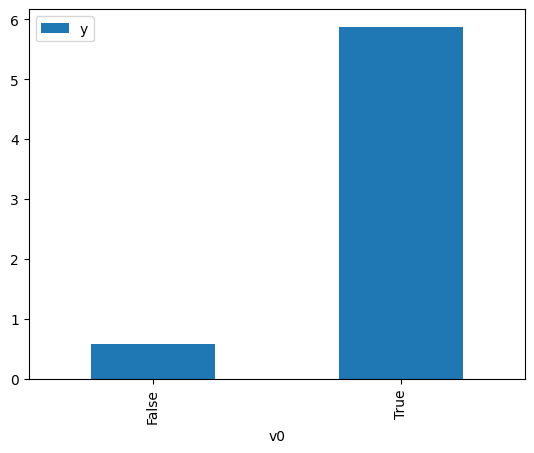

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

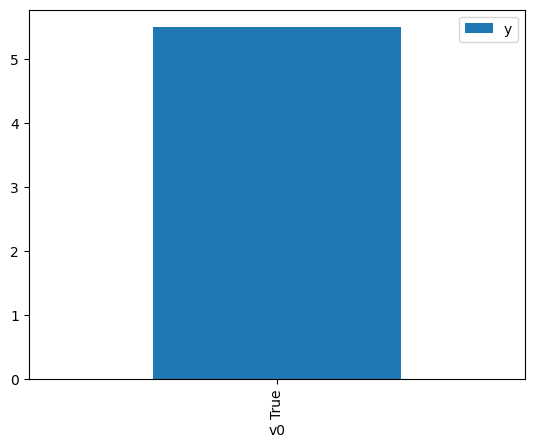

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.779295,False,2.065995,0.437917,2.283538
1,-0.112841,False,-1.440664,0.497885,2.008497
2,1.245058,False,4.040012,0.407207,2.455753
3,-1.885324,False,-4.766155,0.615542,1.624584
4,0.274947,False,0.029156,0.471709,2.119953
...,...,...,...,...,...
995,1.245058,False,4.040012,0.407207,2.455753
996,1.113786,False,2.542085,0.415800,2.405001
997,0.944141,False,1.644084,0.426981,2.342026
998,0.348456,False,2.214265,0.466760,2.142430


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.885176,True,4.039159,0.450088,2.221786
1,1.824535,True,11.232219,0.629988,1.587332
2,0.121790,True,6.155407,0.517964,1.930637
3,-1.578728,True,1.945860,0.404249,2.473723
4,0.657885,True,6.884846,0.553989,1.805090
...,...,...,...,...,...
995,-0.799504,True,2.901983,0.455827,2.193816
996,-0.593804,True,2.709222,0.469650,2.129247
997,0.828322,True,8.555488,0.565342,1.768840
998,0.898718,True,7.132420,0.570012,1.754348


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                          1.234e+04
Date:                Fri, 02 Sep 2022   Prob (F-statistic):                        0.00
Time:                        09:41:20   Log-Likelihood:                         -1444.0
No. Observations:                1000   AIC:                                      2892.
Df Residuals:                     998   BIC:                                      2902.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7057      0.033     82.877      0.000       2.642       2.770
x2             4.9575      0.046    106.857      0.000       4.866       5.048
==============================================================================
Omnibus:                        0.209   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.146
Skew:                           0.024   Prob(JB):                        0.930
Kurtosis:                       3.034   Cond. No.                         1.56
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""